# 【FineTuning】DenseNet121

In [ ]:
!nvidia-smi

Mon Jan 18 23:39:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.3.1          
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.3.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.9.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.2.1          
blis                          0.4.

In [ ]:
!python --version

Python 3.6.9


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ■InputTensor(64, 64, 3)

### Tensorbord

In [ ]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/log1

### create model

In [ ]:
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as  np
import os
import shutil
import tensorflow as tf
import tensorflow.keras.activations as activations

from datetime import datetime, timedelta, timezone
from keras.applications.densenet import *
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.layers import *
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


#-------------------------------------------------------------------------------
# 初期設定
#-------------------------------------------------------------------------------
fpath = '/content/drive/MyDrive/Qiita_share/FineTuning/'

# dense121を扱う場合、 width と height は、32以上にする必要がある。
# https://keras.io/ja/applications/#densenet
img_w, img_h, img_ch = 64, 64, 3
num_classes = 10


#-------------------------------------------------------------------------------
# 前処理
#-------------------------------------------------------------------------------
def pretreatment(x):
    # 画像サイズをリサイズ
    X = []
    for i in range(len(x)):
        dst = cv2.resize(x[i], (img_h, img_w), interpolation=cv2.INTER_CUBIC)
        dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)
        X.append(dst)

    # リシェイプ
    X = np.array(X).reshape(len(x), img_h, img_w, img_ch)

    # 0〜255 までの範囲のデータを 0〜1 までの範囲に変更
    ret = X.astype('float32') / 255
    return ret


#-------------------------------------------------------------------------------
# Create model
#-------------------------------------------------------------------------------
def create_dense121_model():
    input_tensor = x_train.shape[1:]
    # https://keras.io/ja/applications/#densenet
    model = DenseNet121(include_top=False, weights=None, input_shape=input_tensor)
    model.summary()
    print(model.inputs)
    x = Flatten()(model.layers[-1].output)
    x = Dense(num_classes, activation="softmax")(x)
    return Model(model.inputs, x)


#-------------------------------------------------------------------------------
# Get dense121 weight
#-------------------------------------------------------------------------------
dense121_fname = 'org_dense121_weights.hdf5'
fullpath = fpath + dense121_fname
if not os.path.isfile(fullpath) :
    print("`dense121_weights` file does not exist. Downloadig...")
    model = DenseNet121(weights='imagenet')
    model.summary()
    print("Save the `denseNet121_weights` : ", fullpath)
    model.save(fullpath)
else:
    print("`dense121_weights` file exist : ", fullpath)


#-------------------------------------------------------------------------------
# MNIST DL
#-------------------------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)


# ■学習(Train)データ
x_train = pretreatment(x_train)
y_train = np_utils.to_categorical(y_train, num_classes)

# ■学習(Valid)データ
x_valid = pretreatment(x_valid)
y_valid = np_utils.to_categorical(y_valid, num_classes)

# ■テストデータ
x_test = pretreatment(x_test)
y_test = np_utils.to_categorical(y_test, num_classes)

print("---------------------------------------------------------------")
print("x_train:{} y_train:{}".format(x_train.shape, y_train.shape))
print("x_valid:{} y_valid:{}".format(x_valid.shape, y_valid.shape))
print("x_test :{} y_test :{}".format(x_test.shape, y_test.shape))
print("---------------------------------------------------------------")


#-------------------------------------------------------------------------------
# model create
#-------------------------------------------------------------------------------
model = create_dense121_model()
model.summary()

# https://keras.io/ja/optimizers/#adam
opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# dense121のweight読み込み
fullpath = fpath + dense121_fname
print("load the `dense121_weights` : ", fullpath)
model.load_weights(fullpath, by_name=True)


# ------------------------------------------------------------------------------------------------------------
# CallBack設定
# ------------------------------------------------------------------------------------------------------------
# Callback Function 1
fname = 'dense121(1)_Epoch[{epoch:02d}].ValLoss[{val_loss:.3f}].hdf5'
fullpath = fpath + fname
# https://keras.io/ja/callbacks/#modelcheckpoint
callback_func1 = ModelCheckpoint(filepath=fullpath,             # ファイルパス
                                monitor='val_loss',             # 監視する値：val_loss
                                verbose=1,                      # 詳細表示：あり
                                save_best_only=True,            # BESTのときのみ保存：YES
                                save_weights_only=False,        # 重みのみ保存：モデル全体保存
                                mode='min',                     # 監視対象の条件：val_lossのためmin
                                period=1)                       # チェックポイント間の間隔：1epoch毎

# Callback Function 2
# https://keras.io/ja/callbacks/#tensorboard
callback_func2 = keras.callbacks.TensorBoard(log_dir='./logs/log1', histogram_freq=1)

# Callback Function
callbacks = []
callbacks.append(callback_func1)
callbacks.append(callback_func2)


# ------------------------------------------------------------------------------------------------------------
# ImageDataGenerator設定
# ------------------------------------------------------------------------------------------------------------
# https://keras.io/ja/preprocessing/image/#imagedatagenerator
GenTrain = ImageDataGenerator(
    featurewise_center=False,               # データセット全体で,入力の平均を0に調整
    samplewise_center=False,                # 各サンプルの平均を0に調整
    featurewise_std_normalization=False,    # 入力をデータセットの標準偏差で正規化
    samplewise_std_normalization=False,     # 各入力をその標準偏差で正規化
    zca_whitening=False,                    # ZCA白色化のイプシロン
    rotation_range=50,                      # 回転角度(-50～50度)
    width_shift_range=0.3,                  # 左右のスライド幅
    height_shift_range=0.2,                 # 上下のスライド幅
    zoom_range=[1.0,1.5],                   # 拡大・縮小率
    horizontal_flip=False,                  # 水平反転しない
    vertical_flip=False)                    # 垂直反転しない
GenTrain.fit(x_train)

GenValid = ImageDataGenerator(
    featurewise_center=False,               # データセット全体で,入力の平均を0に調整
    samplewise_center=False,                # 各サンプルの平均を0に調整
    featurewise_std_normalization=False,    # 入力をデータセットの標準偏差で正規化
    samplewise_std_normalization=False,     # 各入力をその標準偏差で正規化
    zca_whitening=False,                    # ZCA白色化のイプシロン
    rotation_range=50,                      # 回転角度(-50～50度)
    width_shift_range=0.3,                  # 左右のズレ幅
    height_shift_range=0.2,                 # 上下のズレ幅
    zoom_range=[1.0,1.5],                   # 拡大・縮小率
    horizontal_flip=False,                  # 水平反転しない
    vertical_flip=False)                    # 垂直反転しない
GenValid.fit(x_valid)


# ハイパーパラメータ設定
#          [sample]   [iteration]   [batch size]
# Train ： 48,000   / 1,500         = 32
# Varid ： 20,000   /   625         = 32
epochs = 30
iteration_train = 1500
iteration_valid =  625
batch_size_train = int(x_train.shape[0] / iteration_train)
batch_size_valid = int(x_valid.shape[0] / iteration_valid)

# ImageDataGenerator.flow
# https://keras.io/ja/preprocessing/image/#flow
gen_train_flow = GenTrain.flow(x_train, y_train, batch_size=batch_size_train, seed=99)
gen_valid_flow = GenValid.flow(x_valid, y_valid, batch_size=batch_size_valid, seed=99)


#-------------------------------------------------------------------------------
# Training
#-------------------------------------------------------------------------------
# https://keras.io/ja/models/model/#fit
history = model.fit(gen_train_flow,                         # 訓練データ
                    steps_per_epoch=iteration_train,        # 次のエポックを始めるまでのステップ数の合計
                    epochs=epochs,                          # epoch数
                    validation_data=gen_valid_flow,         # 検証データ
                    validation_steps=iteration_valid,       # バリデーションするステップの総数
                    callbacks=callbacks)                    # コールバック関数定義


#-------------------------------------------------------------------------------
# モデル保存
#-------------------------------------------------------------------------------
fname = 'dense121(1)_GEN.hdf5'
fullpath = fpath + fname
print("Save the 'new model'. : ", fullpath)
model.save(fullpath)


`dense121_weights` file exist :  /content/drive/MyDrive/Qiita_share/FineTuning/org_dense121_weights.hdf5
11493376/11490434 [==============================] - 0s 0us/step
---------------------------------------------------------------
x_train:(48000, 64, 64, 3) y_train:(48000, 10)
x_valid:(12000, 64, 64, 3) y_valid:(12000, 10)
x_test :(10000, 64, 64, 3) y_test :(10000, 10)
---------------------------------------------------------------
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
_____________________________________________

### predict model ▶ 56

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

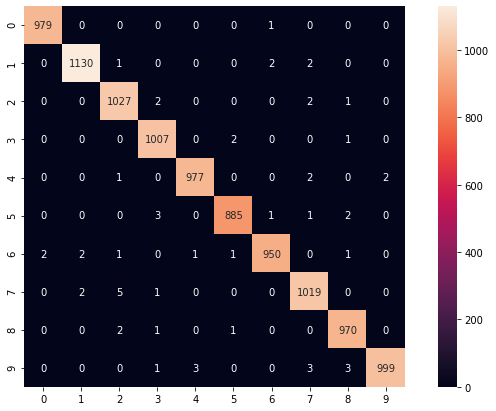


●誤認識表示


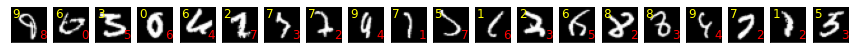

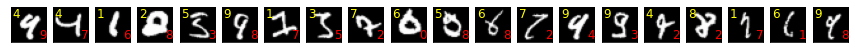

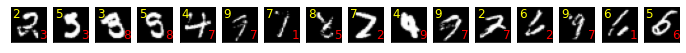

Error Count: 56 / 10000


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn

from keras.datasets import mnist
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


#-------------------------------------------------------------------------------
# 初期値
#-------------------------------------------------------------------------------
num_classes = 10


#-------------------------------------------------------------------------------
# Load Model
#-------------------------------------------------------------------------------
fpath = '/content/drive/MyDrive/Qiita_share/FineTuning/'
fname = 'dense121(1)_GEN.hdf5'
fullpath = fpath + fname

if os.path.isfile(fullpath) :
    model = load_model(fullpath)
    model.summary()
else :
    print("Please make a model first.")

# Input Sizeの自動判別
_, img_w, img_h, img_ch = model.layers[0].input.shape
print("img_w:{} img_h:{} img_ch:{}".format(img_w, img_h, img_ch))


#-------------------------------------------------------------------------------
# MNISTデータ取得
#-------------------------------------------------------------------------------
# x_train：48,000枚
# x_valid：12,000枚
# x_test ：10,000枚
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)


#-------------------------------------------------------------------------------
# 前処理
#-------------------------------------------------------------------------------
def pretreatment(x):
    # 画像サイズをリサイズ
    X = []
    for i in range(len(x)):
        dst = cv2.resize(x[i], (img_h, img_w), interpolation=cv2.INTER_CUBIC)
        if img_ch != 1:
            dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)
        X.append(dst)

    # リシェイプ
    X = np.array(X).reshape(len(x), img_h, img_w, img_ch)

    # 0〜255 までの範囲のデータを 0〜1 までの範囲に変更
    ret = X.astype('float32') / 255
    return ret

x_test = pretreatment(x_test)
y_test = np_utils.to_categorical(y_test, num_classes)

print("x_test", x_test.shape)
print("y_test", y_test.shape)


#-------------------------------------------------------------------------------
# テストデータ1：Evaluate
#-------------------------------------------------------------------------------
score = model.evaluate(x_test, y_test, verbose=1)

print("")
print("●TEST1：検証結果")
print('Test loss:', score[0])
print('Test accuracy:', score[1])


#-------------------------------------------------------------------------------
# テストデータ2：Evaluate
#-------------------------------------------------------------------------------
# ImageDataGenerator設定
# https://keras.io/ja/preprocessing/image/#imagedatagenerator
GenTest = ImageDataGenerator(
    featurewise_center=False,               # データセット全体で,入力の平均を0に調整
    samplewise_center=False,                # 各サンプルの平均を0に調整
    featurewise_std_normalization=False,    # 入力をデータセットの標準偏差で正規化
    samplewise_std_normalization=False,     # 各入力をその標準偏差で正規化
    zca_whitening=False,                    # ZCA白色化のイプシロン
    rotation_range=50,                      # 回転角度(-50～50度)
    width_shift_range=0.3,                  # 左右のズレ幅
    height_shift_range=0.2,                 # 上下のズレ幅
    zoom_range=[1.0,1.5],                   # 拡大・縮小率
    horizontal_flip=False,                  # 水平反転しない
    vertical_flip=False)                    # 垂直反転しない
GenTest.fit(x_test)

# ImageDataGenerator.flow
# https://keras.io/ja/preprocessing/image/#flow
gen_test_flow = GenTest.flow(x_test, y_test, seed=99)

# model.evaluate
# https://keras.io/ja/models/sequential/#evaluate
score = model.evaluate(gen_test_flow, verbose=1)

print("")
print("●TEST2：検証結果")
print('Test loss:', score[0])
print('Test accuracy:', score[1])


#-------------------------------------------------------------------------------
# Predict
#-------------------------------------------------------------------------------
print("")
print("under pred...")
pred = model.predict(x_test)
print("pred comp!")


# ------------------------------------------------------------------------------------------------------------
# 混同行列(コンフュージョンマトリックス)
# ------------------------------------------------------------------------------------------------------------
print("")
print("●混同行列(コンフュージョンマトリックス) 横：識別結果、縦：正解データ")
predict_prob = model.predict(x_test[1:10000, ])
pred_classes = np.argmax(predict_prob,axis=1)
true_classes = np.argmax(y_test[1:10000], 1)
print(confusion_matrix(true_classes, pred_classes))


# ------------------------------------------------------------------------------------------------------------
# ヒートマップ
# ------------------------------------------------------------------------------------------------------------
print("")
print("●ヒートマップ")
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (12,7))
    sn.heatmap(df_cmx, annot=True, fmt='g' ,square = True)
    plt.show()

print_cmx(true_classes, pred_classes)


#-------------------------------------------------------------------------------
# 誤認識表示
#-------------------------------------------------------------------------------
print("")
print("●誤認識表示")
col, num, error = 20, 0, 0
plt.figure(figsize=(15, 1))
for i in range(0, len(pred), col):

    for j in range(col):
        index = i + j
        crct_no = np.argmax(y_test[index, :])
        pred_no = np.argmax(pred[index, :])
        if crct_no != pred_no :
            num += 1
            error += 1
            ax = plt.subplot(1, col, num)               # (1行, 20列, 何番目)
            img = x_test[index].reshape(img_h, img_w, img_ch)
            img = cv2.resize(img, (28, 28))
            plt.gray()
            plt.imshow(img)
            plt.text( 1,  8, str(crct_no), fontsize=12, color='yellow')
            plt.text(22, 25, str(pred_no), fontsize=12, color='red')
            plt.xticks([], "")
            plt.yticks([], "")
            if num >= col:
                num = 0
                plt.show()
                plt.figure(figsize=(15, 1))

plt.show()
plt.close()

print("Error Count: {} / {}".format(error, len(pred)))
